# Hair Segmentation 

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
collab = False

2022-11-10 17:37:06.572243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 17:37:06.684376: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 17:37:07.263037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ndo001/miniconda3/envs/tf/lib/
2022-11-10 17:37:07.263099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

## Import dataset

Found 672 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
Found 168 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


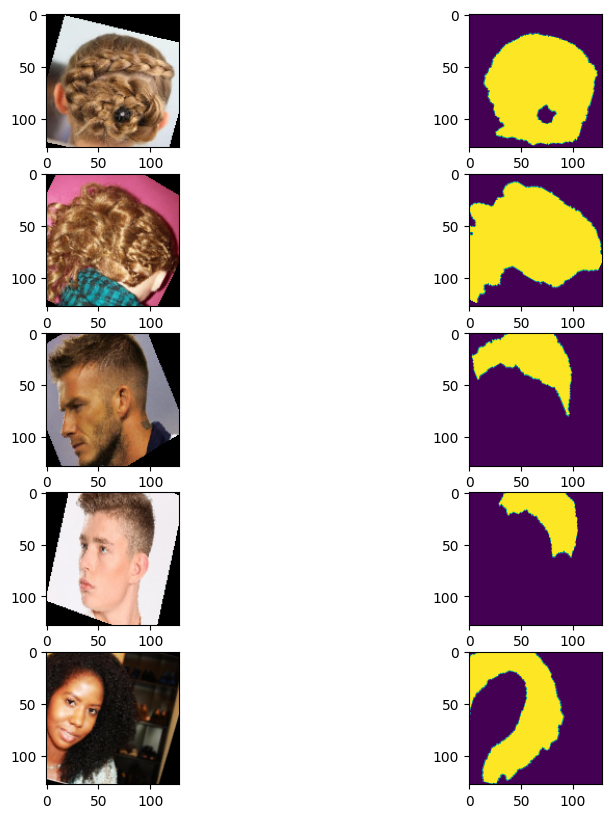

In [4]:
# define dataset dir path
if collab is False:
    root_dir = ''
else :
    root_dir = '/'
    #!unzip /Figaro1k.zip -d /


train_dir = os.path.join(root_dir, 'Figaro1k/Training')
test_dir = os.path.join(root_dir, 'Figaro1k/Testing')

data_gen_args = dict(featurewise_center=False,
    rescale = 1.0/255.0,
    fill_mode = 'constant',
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2
)

image_args = dict(color_mode = "rgb",
    target_size=(128,128),
    class_mode=None,
    batch_size=32,
    seed=42
)

mask_args = dict( target_size=(128, 128), 
    batch_size=32,
    color_mode = "grayscale",
    interpolation = "nearest",  
    class_mode=None,
    seed=42
)
    
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods

image_train_generator = image_datagen.flow_from_directory(
    os.path.join(train_dir, 'imgs'),
    subset='training',
    **image_args)
    
mask_train_generator = mask_datagen.flow_from_directory(
    os.path.join(train_dir, 'masks'),               
    subset='training',
    **mask_args)
    
image_val_generator = image_datagen.flow_from_directory(
    os.path.join(train_dir, 'imgs'),
    subset='validation',
    **image_args)
    
mask_val_generator = mask_datagen.flow_from_directory(
    os.path.join(train_dir, 'masks'),
    subset='validation',
    **mask_args)
    

# combine generators into one which yields image and masks
train_generator = zip(image_train_generator, mask_train_generator)
val_generator = zip(image_val_generator, mask_val_generator)

fig = plt.figure(figsize=(10,10))
i = 0
for generator in train_generator:
    plt.subplot(5,2,1+2*i)
    plt.imshow(generator[0][i])
    plt.subplot(5,2,2+2*i)
    plt.imshow(generator[1][i][:,:,0])
    i += 1
    if i % 5 == 0:
        break

# Generator for test
image_test_datagen = ImageDataGenerator()
image_test_generator = image_test_datagen.flow_from_directory(
    os.path.join(test_dir, 'imgs'),
    color_mode = "rgb",
    target_size=(128,128),
    class_mode=None,
    shuffle=False,
    batch_size=1)

# Gerator for test
mask_test_datagen = ImageDataGenerator()
mask_test_generator = mask_test_datagen.flow_from_directory(
    os.path.join(test_dir, 'masks'),
    color_mode = "grayscale",
    target_size=(128,128),
    class_mode=None,
    shuffle=False,
    batch_size=1)

## Create CNN

In [69]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.losses import BinaryCrossentropy
from keras.metrics import MeanIoU

In [70]:
# Architecture from https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook
inputs = Input((128, 128, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = BatchNormalization()(conv5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)
conv5a = BatchNormalization()(conv5a)

In [71]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = BatchNormalization()(conv6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
conv6a = BatchNormalization()(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6a), conv4], axis=3) #Was conv5 instead of conv6a
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv9 = BatchNormalization()(conv9)
conv10 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)
model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 128, 128, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 128, 128, 32  128        ['conv2d_69[0][0]']              
 ormalization)                  )                                                           

## Train NN

In [72]:
#Create directory to save model and history
num_train = 0
while os.path.isdir(os.path.join(root_dir, 'training_{i}'.format(i=num_train))):
    num_train +=1
save_dir = os.path.join(root_dir, 'training_{i}'.format(i=num_train))
os.makedirs(save_dir)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-7)

#train model
epochs = 100
history = model.fit(train_generator,validation_data=val_generator,epochs=epochs,batch_size=batch_size, steps_per_epoch=len(image_train_generator), validation_steps=len(image_val_generator), callbacks=[reduce_lr])
#history = model.fit(train_generator,epochs=epochs,batch_size=64, steps_per_epoch=len(image_train_generator))
model.save(os.path.join(save_dir, 'model.h5'))
np.save(os.path.join(save_dir, 'my_history.npy') ,history)
    

Epoch 1/100
21/21 [==============================] - 7s 245ms/step - loss: 0.4469 - acc: 0.7857 - val_loss: 47.3437 - val_acc: 0.3442 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 5s 218ms/step - loss: 0.2983 - acc: 0.8670 - val_loss: 291.5369 - val_acc: 0.3418 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 4s 215ms/step - loss: 0.2394 - acc: 0.8900 - val_loss: 122.8927 - val_acc: 0.4230 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 4s 214ms/step - loss: 0.2129 - acc: 0.8989 - val_loss: 138.9360 - val_acc: 0.3231 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 4s 213ms/step - loss: 0.2111 - acc: 0.8991 - val_loss: 60.4874 - val_acc: 0.3564 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 4s 209ms/step - loss: 0.1914 - acc: 0.9072 - val_loss: 5.6507 - val_acc: 0.5880 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 4s 213ms/step - loss: 0.1944 - acc: 0.9074 - val_loss: 40.8671 

INFO:tensorflow:Assets written to: ram://2d4f4e69-80f5-4023-8516-320d614e9554/assets


INFO:tensorflow:Assets written to: ram://2d4f4e69-80f5-4023-8516-320d614e9554/assets


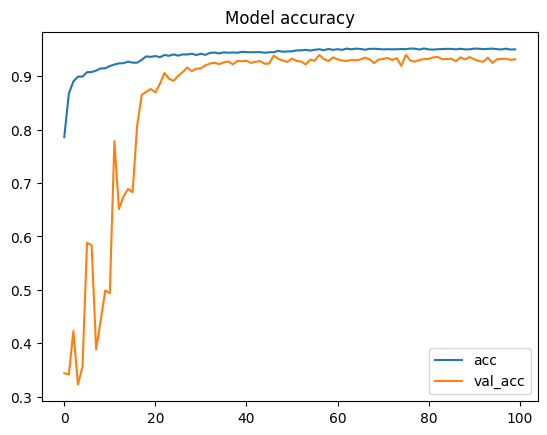

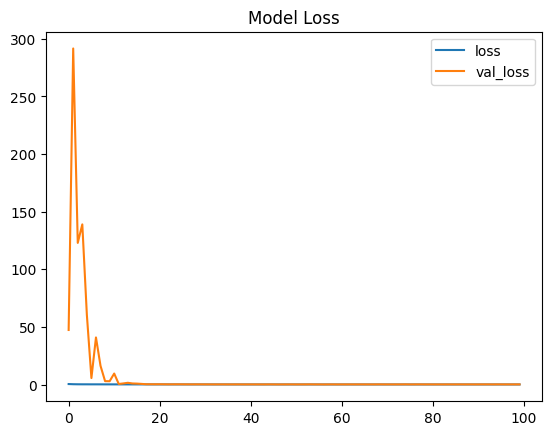

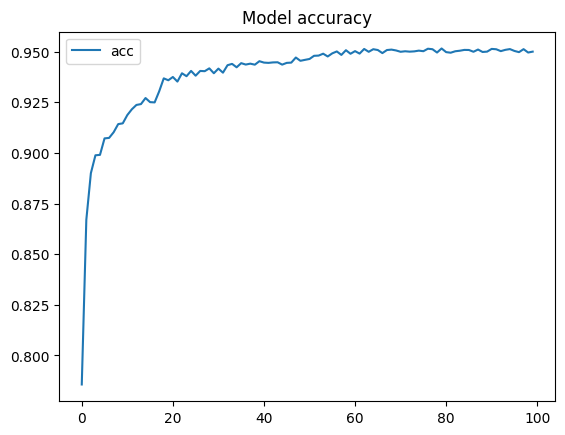

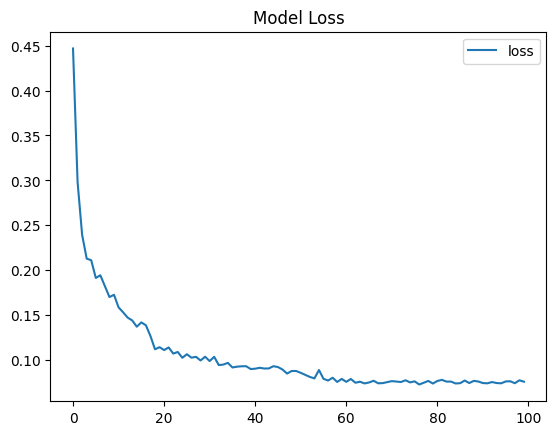

In [73]:
#history=np.load('bce_50epochs_conv6a_history.npy',allow_pickle='TRUE').item()

# Must have been training during this execution
h = history
plt.plot(h.history['acc'], label='acc')
plt.plot(h.history['val_acc'], label='val_acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(h.history['acc'], label='acc')
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.plot(h.history['loss'], label='loss')
plt.legend()
plt.title('Model Loss')
plt.show()

## Predict single image

In [116]:
def predict_and_plot(img_path, model, mask_path=None):
    ncols = 3

    img = np.asarray(Image.open(img_path).resize((128,128)).convert('RGB'))/255.

    if mask_path is not None:
        mask = np.asarray(Image.open(mask_path).resize((128,128)).convert('L'))/255.
        ncols += 1

    pred = model.predict(img[np.newaxis,:,:,:])
    treshold = 0.7
    pred_mask = ((pred > treshold) * 255.)
    
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    plt.subplot(1,ncols,1)
    plt.imshow(img)
    plt.title("Original")
    plt.subplot(1,ncols,2)
    plt.imshow(pred[0])
    plt.title("pred")
    plt.subplot(1,ncols,3)
    plt.imshow(pred_mask[0])
    plt.title("tresholded pred")
    if mask_path is not None:
        plt.subplot(1,ncols,4)
        plt.imshow(mask)
        plt.title("GT")

        score = model.evaluate(img[np.newaxis,:,:,:], mask[np.newaxis,:,:])
        print("accuacy : ", score[1])

### On training data

1/1 [==============================] - 0s 27ms/step - loss: 0.0376 - acc: 0.9838
accuacy :  0.98382568359375


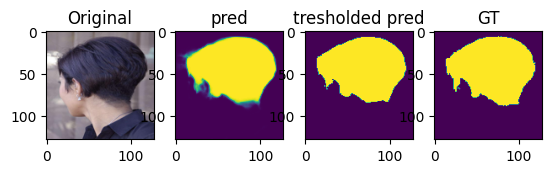

In [117]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

idx = 55
img_dir = os.path.join(train_dir, 'imgs/Original')
images_names = sorted(os.listdir(img_dir))
msk_dir = os.path.join(train_dir, 'masks/GT')
masks_names = sorted(os.listdir(msk_dir))

img_path = os.path.join(img_dir, images_names[idx])
mask_path = os.path.join(msk_dir, masks_names[idx])

predict_and_plot(img_path, model, mask_path)

### On testing data

1/1 [==============================] - 0s 25ms/step - loss: 0.0751 - acc: 0.9667
accuacy :  0.96673583984375


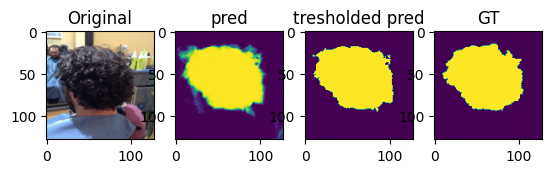

In [118]:
#Load trained model if necessary
#model = load_model('bce_50epochs_conv6a_model.h5')

idx = 80
img_dir = os.path.join(test_dir, 'imgs/Original')
images_names = sorted(os.listdir(img_dir))
msk_dir = os.path.join(test_dir, 'masks/GT')
masks_names = sorted(os.listdir(msk_dir))

img_path = os.path.join(img_dir, images_names[idx])
img = np.asarray(Image.open(img_path).resize((128,128)).convert('RGB'))/255.
mask_path = os.path.join(msk_dir, masks_names[idx])
mask = np.asarray(Image.open(mask_path).resize((128,128)).convert('L'))/255.

predict_and_plot(img_path, model, mask_path)

## Predict n first images

1/1 [==============================] - 0s 19ms/step


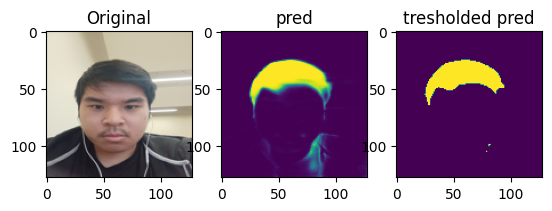

In [119]:
predict_and_plot('./nicolas.jpg', model)